In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from keras.models import Model
# from keras.layers import LSTM, Dense, Input
# import numpy as np
# import matplotlib.pyplot as plt


In [2]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras.models import Model # type: ignore
from keras.layers import LSTM, Dense, Input # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
from keras import backend as K  ## type: ignore

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# GPU를 사용할 수 있으면 사용하도록 설정
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2024-08-17 18:33:28.364311: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 18:33:28.456563: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-17 18:33:28.829964: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 18:33:30.014404: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  0


In [3]:
# %pip show tensorflow
# %pip show keras


In [4]:
# 한글 폰트 설정
def set_korean_font():
    plt.rcParams['font.family'] = 'Noto Sans CJK JP'
    plt.rcParams['font.sans-serif'] = ['Noto Serif CJK JP']

In [5]:
# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers_to_ohbin(numbers):
    ohbin = np.zeros(45)
    for number in numbers:
        index = int(number) - 1
        ohbin[index] = 1
    return ohbin

# 데이터를 원핫인코딩벡터로 변환하여 반환
def prepare_data(file_path):
    rows = np.loadtxt(file_path, delimiter=",")
    print(rows.shape)

    x_samples = [numbers_to_ohbin(row[1:7]) for row in rows[:-1]]
    y_samples = [numbers_to_ohbin(row[1:7]) for row in rows[1:]]
    return np.expand_dims(np.array(x_samples), axis=1), np.array(y_samples)


In [6]:
# LSTM을 사용하는 모델을 생성합니다.
def create_model(input_shape):
    inputs = Input(shape=(1, 45))
    lstm = LSTM(128, return_sequences=False, stateful=False)(inputs)
    outputs = Dense(45, activation='sigmoid')(lstm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [7]:
# 훈련 및 테스트 함수
def train_and_test_model(model, X_train, y_train, X_test, y_test, epochs, batch_size, memory_cleanup_interval):
    train_loss = []
    test_loss = []
    for epoch in range(epochs):
        batch_train_loss = []
        for i in range(0, X_train.shape[0], batch_size):
            # print(f'epoch {epoch+1}/{epochs} 훈련 {i}/{X_train.shape[0]}')
            xs, ys = X_train[i:i+batch_size], y_train[i:i+batch_size]
            loss, _ = model.train_on_batch(xs, ys)
            batch_train_loss.append(loss)
        train_loss.append(np.mean(batch_train_loss))
        # print(f'에포크 {epoch + 1:3d} 훈련 손실: {train_loss[-1]:.4f}')

        # 테스트 데이터로 평가
        batch_test_loss = []
        for i in range(0, X_test.shape[0], batch_size):
            xs, ys = X_test[i:i+batch_size], y_test[i:i+batch_size]
            loss, _ = model.test_on_batch(xs, ys)
            batch_test_loss.append(loss)
            # print(f'epoch {epoch+1}/{epochs} 테스트 {i}/{X_test.shape[0]}')
        test_loss.append(np.mean(batch_test_loss))
        # print(f'에포크 {epoch + 1:3d} 테스트 손실: {test_loss[-1]:.4f}')

        # 메모리 해제
        if (epoch + 1) % memory_cleanup_interval == 0:
            K.clear_session()
            print(f'메모리 해제 완료 :: 에포크 {epoch + 1:3d} 훈련 손실: {train_loss[-1]:.4f} 테스트 손실: {test_loss[-1]:.4f}')

    return train_loss, test_loss

In [8]:
# 추론된 확률을 기반으로 당첨 번호를 생성합니다.
def gen_numbers_from_probability(nums_prob):
    ball_box = []
    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1)  # 1부터 시작
        ball_box += list(ball)

    selected_balls = []
    while len(selected_balls) < 6:
        ball_index = np.random.randint(len(ball_box))
        ball = ball_box[ball_index]
        if ball not in selected_balls:
            selected_balls.append(ball)
    return sorted(selected_balls)

In [9]:
# 손실 그래프 생성
def plot_loss(train_loss, test_loss):

    print(f'train_loss {train_loss[-1]} test_loss: {test_loss[-1]}')

    plt.plot(train_loss, label='훈련 손실')
    plt.plot(test_loss, label='테스트 손실')
    plt.xlabel('에포크')
    plt.ylabel('손실')
    plt.legend()
    plt.show()


In [10]:
# # 메인 함수
# def main():

#     # 한글 폰트 설정
#     set_korean_font()

#     # 데이터 준비
#     X_train, y_train = prepare_data("./lotto.csv")
#     # 임시로 훈련 데이터를 테스트 데이터로 사용
#     X_test, y_test = X_train, y_train  

#     # 모델 생성
#     model = create_model(input_shape=(1, 45))

#     # 모델 훈련 및 손실 기록 (배치 크기를 32로 설정, 메모리 해제 주기를 10으로 설정)
#     train_loss, test_loss = train_and_test_model(model, X_train, y_train, X_test, y_test, epochs=200, batch_size=32, memory_cleanup_interval=10)        
#     print("훈련 및 테스트 완료")

#     # 마지막 회차까지 학습한 모델로 다음 회차 추론
#     xs = X_train[-1].reshape(1, 1, 45)
#     ys_pred = model.predict_on_batch(xs)

#     for n in range(5):
#         numbers = gen_numbers_from_probability(ys_pred[0])
#         print(f'{n}: {numbers}')

#     # 손실 그래프 생성
#     plot_loss(train_loss, test_loss) 

# # 메인 함수 실행
# if __name__ == "__main__":
#     main()


In [11]:
# 한글 폰트 설정
set_korean_font()

# 데이터 준비
X_train, y_train = prepare_data("./lotto.csv")
# 임시로 훈련 데이터를 테스트 데이터로 사용
X_test, y_test = X_train, y_train  

# 모델 생성
model = create_model(input_shape=(1, 45))

# 모델 훈련 및 손실 기록 (배치 크기를 32로 설정, 메모리 해제 주기를 10으로 설정)
train_loss, test_loss = train_and_test_model(model, X_train, y_train, X_test, y_test, epochs=54, batch_size=32, memory_cleanup_interval=10)        
print("훈련 및 테스트 완료")

# 마지막 회차까지 학습한 모델로 다음 회차 추론
xs = X_train[-1].reshape(1, 1, 45)
ys_pred = model.predict_on_batch(xs)



(132, 13)
메모리 해제 완료 :: 에포크  10 훈련 손실: 0.6296 테스트 손실: 0.6238
메모리 해제 완료 :: 에포크  20 훈련 손실: 0.5234 테스트 손실: 0.5200
메모리 해제 완료 :: 에포크  30 훈련 손실: 0.4767 테스트 손실: 0.4751
메모리 해제 완료 :: 에포크  40 훈련 손실: 0.4520 테스트 손실: 0.4511
메모리 해제 완료 :: 에포크  50 훈련 손실: 0.4356 테스트 손실: 0.4349
메모리 해제 완료 :: 에포크  60 훈련 손실: 0.4231 테스트 손실: 0.4225
메모리 해제 완료 :: 에포크  70 훈련 손실: 0.4127 테스트 손실: 0.4122
메모리 해제 완료 :: 에포크  80 훈련 손실: 0.4035 테스트 손실: 0.4031
메모리 해제 완료 :: 에포크  90 훈련 손실: 0.3952 테스트 손실: 0.3948
메모리 해제 완료 :: 에포크 100 훈련 손실: 0.3873 테스트 손실: 0.3869
훈련 및 테스트 완료


In [12]:
for n in range(5):
    numbers = gen_numbers_from_probability(ys_pred[0])
    print(f'{n}: {numbers}')



0: [6, 7, 19, 34, 38, 41]
1: [7, 15, 19, 34, 41, 44]
2: [6, 7, 19, 25, 34, 38]
3: [6, 7, 28, 34, 41, 44]
4: [6, 7, 14, 19, 28, 41]


train_loss 0.38125327229499817 test_loss: 0.38087746500968933


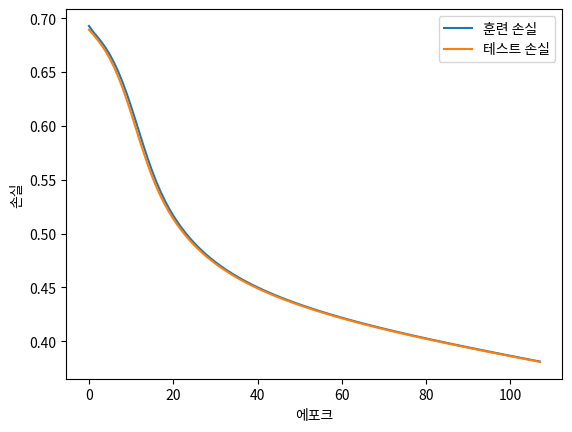

In [13]:
# 손실 그래프 생성
plot_loss(train_loss, test_loss) 